# Training the Transformers with 2018 data

Following the "main.py" script in tranad/

In [19]:
import os
import sys
import json
from time import time
from pprint import pprint

sys.path.append('../')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

#from src.models import *
# from src.constants import *
# from src.plotting import *
# from src.pot import *
#from src.utils import *
# from src.diagnosis import *
# from src.merlin import *
from transformer_based_detection.tranad.src.dataset_loader_hlt_datasets import HLTDataset
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
from torch.utils.tensorboard import SummaryWriter
from sklearn.preprocessing import MinMaxScaler

#from torch_profiling_utils.torchinfowriter import TorchinfoWriter
#from torch_profiling_utils.fvcorewriter import FVCoreWriter



In [20]:
class color:
    HEADER = '\033[95m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    RED = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [21]:
def load_dataset(dataset):

    loader = []

    if 'HLT' in dataset:

        data_source = dataset.rsplit('_', maxsplit=1)[0]
        variant = int(dataset.split('_')[-1])
        print(data_source)
        print(variant)

        train_set = HLTDataset(data_source, variant,
                                        'train', False,
                                        'minmax', 'train_set_fit',
                                        applied_augmentations=\
                                                args.augmentations,
                                        augmented_dataset_size_relative=\
                                                args.augmented_dataset_size_relative,
                                        augmented_data_ratio=\
                                                args.augmented_data_ratio)

        folder = f'./checkpoints/{args.model}_{args.dataset}_{augmentation_string}_seed_{int(args.seed)}/'

        os.makedirs(folder, exist_ok=True)
        train_set.pickle_scaler(f'{folder}/scaler.pkl')

        loader.append(train_set.get_data())

        test_set = HLTDataset(data_source, variant,
                                        'test', False,
                                        'minmax', 'train_set_fit',
                                        applied_augmentations=\
                                                args.augmentations,
                                        augmented_dataset_size_relative=\
                                                args.augmented_dataset_size_relative,
                                        augmented_data_ratio=\
                                                args.augmented_data_ratio)

        loader.append(test_set.get_data())
        loader.append(test_set.get_labels())
        
    #if args.less:
    #    loader[0] = cut_array(0.2, loader[0])

    print(f'Train shape: {loader[0].shape}')
    print(f'Test shape: {loader[1].shape}')

    train_loader = DataLoader(loader[0], batch_size=loader[0].shape[0])
    test_loader = DataLoader(loader[1], batch_size=loader[1].shape[0])
    labels = loader[2]

    return train_loader, test_loader, labels

In [22]:
def save_model(model, optimizer, scheduler, epoch, accuracy_list):
    folder = f'checkpoints/{args.model}_{args.dataset}_{augmentation_string}_seed_{int(args.seed)}/'

    os.makedirs(folder, exist_ok=True)
    file_path = f'{folder}/model.ckpt'
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'accuracy_list': accuracy_list}, file_path)


# DAGMM (Deep Autoencoding Gaussian Mixture Model)

1. Autoencoder: Compresses the input data into a lower-dimensional latent representation.
1. Reconstruction Error Metrics: Computes reconstruction errors (e.g., relative Euclidean distance and cosine similarity) between the original and reconstructed data.
1. Estimation Network (GMM): Takes the latent representation and reconstruction errors to estimate the parameters of a GMM.
1. Energy Function: Computes the energy (negative log-likelihood) of the samples under the estimated GMM.
1. Loss Function: Combines the reconstruction loss, the sample energy, and a regularization term on the covariance matrices.





- An autoencoder with an estimation network for GMM parameters. Reconstruction errors are used to enhance the latent representation.
- Combines reconstruction loss, sample energy, and covariance regularization.
- Windowing is essential for time series data. Flattened windows are used as inputs to the model.
- Iterate over the data, compute the loss, and update the model parameters.
- During testing, compute the sample energy as the anomaly score. Analyze the energy scores to identify anomalies.







1. Autoencoder

    - Dimensionality Reduction: Compresses input data into a latent space.
    - Feature Learning: Captures essential patterns and structures in the data.
    - Reconstruction: Attempts to reconstruct the input from the latent representation.

How it works:

- Encoder: Maps input data $\mathbf{x}$ to a latent representation $\mathbf{z}$:  

$$
\mathbf{z} = f_{\text{enc}}(\mathbf{x}; \theta_{\text{enc}})
$$

- Decoder: Reconstructs the input from $\mathbf{z}$:

$$
\hat{\mathbf{x}} = f_{\text{dec}}(\mathbf{z};\, \theta_{\text{dec}})
$$

- Training Objective: Minimize the reconstruction loss:

$$
L_{\text{recon}} = \frac{1}{N} \sum_{i=1}^{N} \left\| \mathbf{x}_i - \hat{\mathbf{x}}_i \right\|^2
$$

The autoencoder is trained primarily on normal (non-anomalous) data, learning to reconstruct these patterns accurately. Unseen or rare patterns (anomalies) are reconstructed poorly, resulting in higher reconstruction errors.

2. Reconstruction Error Metrics

Reconstruction errors provide cues about how well the model represents each data point. Combining reconstruction errors with latent representations enhances the model's ability to detect anomalies.

   1. **Relative Euclidean Distance (RED)**:

   $$
   \text{RED} = \frac{\left\| \mathbf{x} - \hat{\mathbf{x}} \right\|_2}{\left\| \mathbf{x} \right\|_2}
   $$

   2. **Cosine Similarity (CS)**:

   $$
   \text{CS} = \frac{\mathbf{x}^\top \hat{\mathbf{x}}}{\left\| \mathbf{x} \right\|_2 \left\| \hat{\mathbf{x}} \right\|_2}
   $$

Higher RED: Indicates poor reconstruction, potential anomaly.
Lower CS: Indicates dissimilarity between input and reconstruction.


3. Estimation Network and Gaussian Mixture Model (GMM)

Density Estimation: Models the distribution of latent representations and reconstruction errors.
Anomaly Scoring: Identifies data points that deviate from the learned distribution.

- **Input to Estimation Network**:

  $$
  \mathbf{v} = \left[ \mathbf{z},\, \text{RED},\, \text{CS} \right]
  $$

  - Concatenation of latent representation and reconstruction error metrics.

- **Estimation Network**: Outputs mixture component assignments (soft clustering):

  $$
  \boldsymbol{\gamma} = f_{\text{est}}(\mathbf{v};\, \theta_{\text{est}})
  $$

  - $\boldsymbol{\gamma} \in \mathbb{R}^K$, where $K$ is the number of Gaussian components.
  - Activation function: Softmax to ensure $\sum_{k=1}^{K} \gamma_{ik} = 1$ for each data point $i$.

- **GMM Parameters Estimation**:

  - **Mixture Weights**:

    $$
    \phi_k = \frac{1}{N} \sum_{i=1}^{N} \gamma_{ik}
    $$

  - **Means**:

    $$
    \boldsymbol{\mu}_k = \frac{\sum_{i=1}^{N} \gamma_{ik} \mathbf{v}_i}{\sum_{i=1}^{N} \gamma_{ik}}
    $$

  - **Covariances**:

    $$
    \boldsymbol{\Sigma}_k = \frac{\sum_{i=1}^{N} \gamma_{ik} \left( \mathbf{v}_i - \boldsymbol{\mu}_k \right) \left( \mathbf{v}_i - \boldsymbol{\mu}_k \right)^\top}{\sum_{i=1}^{N} \gamma_{ik}}
    $$

#### Energy Function (Anomaly Score)

  $$
  E(\mathbf{v}_i) = -\log \left( \sum_{k=1}^{K} \phi_k \cdot \mathcal{N} \left( \mathbf{v}_i \mid \boldsymbol{\mu}_k,\, \boldsymbol{\Sigma}_k \right) \right)
  $$

  - $\mathcal{N}(\mathbf{v}_i \mid \boldsymbol{\mu}_k,\, \boldsymbol{\Sigma}_k)$ is the Gaussian probability density function for component $k$.

  - **Low Energy**: Data point is likely under the model (considered normal).
  - **High Energy**: Data point is unlikely under the model (potential anomaly).


4. Joint Optimization

The total loss function combines:

1. **Reconstruction Loss**:

   $$
   L_{\text{recon}} = \frac{1}{N} \sum_{i=1}^{N} \left\| \mathbf{x}_i - \hat{\mathbf{x}}_i \right\|^2
   $$

2. **Sample Energy**:

   $$
   L_{\text{energy}} = \frac{1}{N} \sum_{i=1}^{N} E(\mathbf{v}_i)
   $$

3. **Covariance Regularization**:

   $$
   L_{\text{cov}} = \sum_{k=1}^{K} \frac{1}{\left\| \boldsymbol{\Sigma}_k \right\|_F^2}
   $$

   - $\left\| \cdot \right\|_F$ denotes the Frobenius norm.

#### Total Loss Function

The overall objective is to minimize:

$$
L_{\text{total}} = L_{\text{recon}} + \lambda_{\text{energy}} \cdot L_{\text{energy}} + \lambda_{\text{cov}} \cdot L_{\text{cov}}
$$

- $\lambda_{\text{energy}}$, $\lambda_{\text{cov}}$: Regularization coefficients controlling the importance of each term.

#### Training Process

- **Joint Training**: The autoencoder and estimation network are trained simultaneously to optimize the total loss.
- **Backpropagation**: Gradients are computed for all components, and parameters are updated using optimization algorithms.
- **Benefit**: Ensures that the latent space is structured in a way that is conducive to density estimation and effective anomaly detection.




In [23]:
## DAGMM Model (ICLR 18)

#self.n_feats: Number of features in the dataset.
#self.n_hidden: Size of the hidden layers.
#self.n_latent: Size of the latent representation.
#self.n_window: Window size for time series data (since we're dealing with sequences).
#self.n: Total input size after windowing (n_feats * n_window).
#self.n_gmm: Number of Gaussian mixture components (set equal to n).
                                                 
class DAGMM(nn.Module):
    def __init__(self, feats):
        super(DAGMM, self).__init__()
        self.name = 'DAGMM'
        self.lr = 0.0001
        self.beta = 0.01
        self.n_feats = feats
        self.n_hidden = 16
        self.n_latent = 8
        self.n_window = 5 # DAGMM w_size = 5
        self.n = self.n_feats * self.n_window
        self.n_gmm = self.n_feats * self.n_window
        self.encoder = nn.Sequential(
            nn.Linear(self.n, self.n_hidden), nn.Tanh(),
            nn.Linear(self.n_hidden, self.n_hidden), nn.Tanh(),
            nn.Linear(self.n_hidden, self.n_latent)
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.n_latent, self.n_hidden), nn.Tanh(),
            nn.Linear(self.n_hidden, self.n_hidden), nn.Tanh(),
            nn.Linear(self.n_hidden, self.n), nn.Sigmoid(),
        )
        # Estimation network:
        #Input: Concatenation of latent representation and 2 reconstruction error metrics.
        #Output: Gamma (mixture component probabilities).
        #Activation: Tanh, followed by Softmax to ensure the output sums to 1.
        self.estimate = nn.Sequential(
            nn.Linear(self.n_latent+2, self.n_hidden), nn.Tanh(), nn.Dropout(0.5),
            nn.Linear(self.n_hidden, self.n_gmm), nn.Softmax(dim=1),
        )

    def compute_reconstruction(self, x, x_hat):
        # Reconstruction Error Metrics
        #Relative Euclidean Distance: Measures the reconstruction error 
        #                             relative to the norm of the original input.
        # Cosine Similarity: Measures the angle between the original and 
        #                    reconstructed input vectors.
        relative_euclidean_distance = (x-x_hat).norm(2, dim=1) / x.norm(2, dim=1)
        cosine_similarity = F.cosine_similarity(x, x_hat, dim=1)
        return relative_euclidean_distance, cosine_similarity

    def forward(self, x):
        ## Encode Decoder
        x = x.view(1, -1) # Flatten the input
        z_c = self.encoder(x) # Encode to get latent representation z_c
        x_hat = self.decoder(z_c) # Decode to reconstruct x_hat
        ## Compute Reconstruction errors
        rec_1, rec_2 = self.compute_reconstruction(x, x_hat)
        z = torch.cat([z_c, rec_1.unsqueeze(-1), rec_2.unsqueeze(-1)], dim=1) # Concatenate z_c with reconstruction errors to form z.
        ## Estimate gamma
        gamma = self.estimate(z) # Pass z through the estimation network to get gamma.
        return z_c, x_hat.view(-1), z, gamma.view(-1)

In [24]:
# Convert the sequential data into windowed samples.
def convert_to_windows(data, model):
    windows = []; w_size = model.n_window
    for i, g in enumerate(data): 
        if i >= w_size: w = data[i-w_size:i]
        # If there aren't enough previous steps, pad with the first data point.
        else: w = torch.cat([data[0].repeat(w_size-i, 1), data[0:i]])
        windows.append(w if 'TranAD' in args.model or 'Attention' in args.model else w.view(-1))
    return torch.stack(windows)

def load_model(modelname, dims):
    #import src.models
    #model_class = getattr(src.models, modelname)
    model_class = globals().get(modelname)
    model = model_class(dims).double()
    optimizer = torch.optim.AdamW(model.parameters() , lr=model.lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, 0.9)
    fname = f'checkpoints/{args.model}_{args.dataset}_{augmentation_string}_seed_{int(args.seed)}/model.ckpt'

    if os.path.exists(fname) and (not args.retrain or args.test):

        print(f"{color.GREEN}Loading pre-trained model: {model.name}{color.ENDC}")
        checkpoint = torch.load(fname)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        epoch = checkpoint['epoch']
        accuracy_list = checkpoint['accuracy_list']

    else:
        print(f"{color.GREEN}Creating new model: {model.name}{color.ENDC}")
        epoch = -1; accuracy_list = []
    return model, optimizer, scheduler, epoch, accuracy_list


In [25]:
import argparse

args_dict = {
    "use_gpu": True,
    "use_multi_gpu": False,
    "seed":42, 
    #"dataset": "HLT_2018",
    "dataset": "HLT_DCM_2018",
    #"dataset": "HLT_2023",
    #"dataset": "HLT_DCM_2023",
    "checkpoints": "./checkpoints",
    "loss": "MSE",
    "learning_rate": 0.00009727998365755187,
    "num_workers": 8, # Before was 0
    "train_epochs": 10,
    "batch_size": 256, # Before was 128
    "patience": 3,
    "model": "DAGMM",
    "retrain": True,
    #"retrain": False,
    "test": False,
    #"test": True,
    "apply_augmentations": True,
    #"apply_augmentations": False,
    #"augmentations": ['Scale:0.8,1.0', 'Scale_APP:0.8,1.0,0.01,0.05,0.05'],
    "augmentations": ['Scale:1.0,1.2', 'Scale_APP:1.0,1.2,0.01,0.01,0.01'], 
    #"augmentations": [],
    "augmented_dataset_size_relative": 1.0,
    "augmented_data_ratio": 0.25
    #"augmented_data_ratio": 0
}

# Convert the dictionary to an argparse.Namespace object
args = argparse.Namespace(**args_dict)

In [26]:
torch.manual_seed(args.seed)



# We're doing no augmentations for the moment!
augmentations = []

if args.apply_augmentations:

    augmentation_string = ''

    for augmentation in args.augmentations:
        augmentation = augmentation.replace(' ', '')
        aug_type, factors = augmentation.split(':')

        factors = factors.split(',')

        factors_string = '_'.join(factors)

        factors = [float(factor) for factor in factors]

        if len(augmentation_string):
            augmentation_string += '_'

        augmentation_string += aug_type + '_' +\
                                    factors_string

        augmentations.append((aug_type, factors))

    augmentation_string += f'_rel_size_{args.augmented_dataset_size_relative}'\
                                        f'_ratio_{args.augmented_data_ratio:.2f}'


if args.augmented_data_ratio == 0:
    augmentation_string = 'no_augment'

args.augmentations = augmentations

print(augmentation_string)
print(augmentations)

print(args.dataset)

Scale_1.0_1.2_Scale_APP_1.0_1.2_0.01_0.01_0.01_rel_size_1.0_ratio_0.25
[('Scale', [1.0, 1.2]), ('Scale_APP', [1.0, 1.2, 0.01, 0.01, 0.01])]
HLT_DCM_2018


In [27]:
os.system('pwd')
os.system('hostname')

/home/kstehle/Documents/phd/strada
at-tdaq-mldev01


0

In [28]:
device = "cuda:0"

train_loader, test_loader, labels = load_dataset(args.dataset)
#train_loader, test_loader, labels = load_dataset_indiv(args.dataset)
print(labels.shape, labels.shape[1])
model, optimizer, scheduler, epoch, accuracy_list = load_model(args.model, labels.shape[1])

model.to(device)

## Prepare data

trainD, testD = next(iter(train_loader)), next(iter(test_loader))
trainO, testO = trainD, testD
if model.name in ['Attention', 'DAGMM', 'USAD', 'MSCRED', 'CAE_M', 'GDN', 'MTAD_GAT', 'MAD_GAN'] or 'TranAD' in model.name: 
    trainD, testD = convert_to_windows(trainD, model), convert_to_windows(testD, model)

model.to(device)

HLT_DCM
2018
HLT_DCM
HLT_DCM
Train shape: (47055, 102)
Test shape: (27955, 102)
(27955, 102) 102
Creating new model: DAGMM


DAGMM(
  (encoder): Sequential(
    (0): Linear(in_features=510, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=8, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=510, bias=True)
    (5): Sigmoid()
  )
  (estimate): Sequential(
    (0): Linear(in_features=10, out_features=16, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=16, out_features=510, bias=True)
    (4): Softmax(dim=1)
  )
)

In [29]:
def backprop(epoch,                   # Current epoch number.
                model,                #
                data,                 # Windowed data.
                dataO,                # Original data (used for feature size).
                optimizer,            # 
                scheduler,            # Learning rate scheduler.
                training=True,        # Training or Validation?
                summary_writer=None,  # For logging
                dataset_name=None):    

    # Loss Function
    # Training: Uses mean reduction to compute the average loss.
    # Validation: Uses 'none' reduction to compute the loss per sample.
    l = nn.MSELoss(reduction = 'mean' if training else 'none')
    feats = dataO.shape[1]

    data_train_list = []
    preds_train_list = []
    data_test_list = []
    preds_test_list = []


    if 'DAGMM' in model.name:
        l = nn.MSELoss(reduction = 'none')
        # To compute the energy and covariance regularization terms.
        # compute = ComputeLoss(model, 0.1, 0.005, device, model.n_gmm)
        n = epoch + 1; w_size = model.n_window
        l1s = []; l2s = []

        data = data.to(device)

        train_steps = len(data)

        

        if training:
            for i, d in enumerate(tqdm(data)):
                d = d.to(device)
                _, x_hat, z, gamma = model(d)
                l1, l2 = l(x_hat, d), l(gamma, d)
                l1s.append(torch.mean(l1).item()); l2s.append(torch.mean(l2).item())
                loss = torch.mean(l1) + torch.mean(l2)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if (i % 1024) == 0:

                    log_gradients_in_model(model,
                                            summary_writer,
                                            i + epoch*train_steps)

                    summary_writer.add_scalar("L1 loss",
                                                np.mean(l1s),
                                                i + epoch*train_steps)

                    summary_writer.add_scalar("L2 loss",
                                                np.mean(l2s),
                                                i + epoch*train_steps)


            #print(l1s, l2s)
            scheduler.step()
            tqdm.write(f'Epoch {epoch},\tL1 = {np.mean(l1s)},\tL2 = {np.mean(l2s)}')
            return np.mean(l1s)+np.mean(l2s), optimizer.param_groups[0]['lr']
        
        # if training:
        #     total_loss = 0
        #     for d in data:
        #         d = d.to(device)
        #         z_c, x_hat, z, gamma = model(d)
        #         loss = compute.forward(d.view(1, -1), x_hat.view(1, -1), z, gamma.view(1, -1))
        #         optimizer.zero_grad()
        #         loss.backward()
        #         optimizer.step()
        #         total_loss += loss.item()
        #     scheduler.step()
        #     avg_loss = total_loss / len(data)
        #     tqdm.write(f'Epoch {epoch},\tLoss = {avg_loss}')
        #     return avg_loss, optimizer.param_groups[0]['lr']
        
        else:
            ae1s = []

            for d in data:
                # d = d.to(device)
                _, x_hat, _, _ = model(d)
                ae1s.append(x_hat)
            ae1s = torch.stack(ae1s)
            y_pred = ae1s[:, data.shape[1]-feats:data.shape[1]].view(-1, feats)
            loss = l(ae1s, data)[:, data.shape[1]-feats:data.shape[1]].view(-1, feats)
            return loss.detach().cpu().numpy(), y_pred.detach().cpu().numpy()
                       
                       
        # else:
        #     anomaly_scores = []
        #     for d in data:
        #         d = d.to(device)
        #         z_c, x_hat, z, gamma = model(d)
        #         sample_energy, _ = compute.compute_energy(z, gamma)
        #         anomaly_scores.append(sample_energy.item())
        #     return anomaly_scores

In [30]:
def log_gradients_in_model(model, summary_writer, step):
    for tag, value in model.named_parameters():
        if value.grad is not None:
            summary_writer.add_histogram(tag, value.cpu(), step)
            summary_writer.add_histogram(tag + "/grad", value.grad.cpu(), step)
            

def _save_numpy_array(array: np.array, filename: str):
    
    # Create all necessary directories in the path if they don't exist
    directory = os.path.dirname(filename)
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    with open(filename, 'wb') as output_file:
        np.save(output_file, array)

In [31]:
def plot_accuracies(accuracy_list, folder):
    os.makedirs(f'plots/{folder}/', exist_ok=True)
    trainAcc = [i[0] for i in accuracy_list]
    lrs = [i[1] for i in accuracy_list]
    plt.xlabel('Epochs')
    plt.ylabel('Average Training Loss')
    plt.plot(range(len(trainAcc)), trainAcc, label='Average Training Loss', linewidth=1, linestyle='-', marker='.')
    plt.twinx()
    plt.plot(range(len(lrs)), lrs, label='Learning Rate', color='r', linewidth=1, linestyle='--', marker='.')
    plt.savefig(f'plots/{folder}/training-graph.pdf')
    plt.clf()

In [32]:
#Computes the loss function as per the DAGMM paper, including:
#
#    Reconstruction Loss: Between the original input x and the reconstructed output x_hat.
#    Sample Energy: Negative log-likelihood under the GMM.
#    Covariance Regularization: Encourages the covariance matrices to be well-conditioned.
from torch.autograd import Variable
class ComputeLoss:
    def __init__(self, model, lambda_energy, lambda_cov, device, n_gmm):
        self.model = model
        self.lambda_energy = lambda_energy
        self.lambda_cov = lambda_cov
        self.device = device
        self.n_gmm = n_gmm
    
    # Cumputes the total loss and returns a scalar loss tensor for backpropagation
    def forward(self, x, x_hat, z, gamma):
        """Computing the loss function for DAGMM."""
        reconst_loss = torch.mean((x-x_hat).pow(2))

        sample_energy, cov_diag = self.compute_energy(z, gamma)

        loss = reconst_loss + self.lambda_energy * sample_energy + self.lambda_cov * cov_diag
        #return Variable(loss, requires_grad=True)
        return loss
    
#     def compute_energy(self, z, gamma, phi=None, mu=None, cov=None, sample_mean=True):
#         """Computing the sample energy function"""
#         if (phi is None) or (mu is None) or (cov is None):
#             phi, mu, cov = self.compute_params(z, gamma)

#         eps = 1e-12
#         K, D = cov.shape[0], cov.shape[1]

#         # Add small value to the diagonal for numerical stability
#         cov += eps * torch.eye(D, device=self.device).unsqueeze(0)

#         # Compute the inverse and determinant of covariance matrices using batch operations
#         cov_inverse = torch.inverse(cov)  # Shape: K x D x D

#         # Use custom Cholesky function in batch mode
#         L = torch.cholesky(cov * (2 * np.pi))  # Shape: K x D x D
#         det_cov = torch.prod(torch.diagonal(L, dim1=-2, dim2=-1), dim=1) ** 2  # Shape: K

#         # Compute Mahalanobis distance
#         z_mu = z.unsqueeze(1) - mu.unsqueeze(0)  # Shape: N x K x D
#         z_mu = z_mu.unsqueeze(-1)  # Shape: N x K x D x 1

#         # Expand cov_inverse to match z_mu dimensions
#         cov_inverse_expanded = cov_inverse.unsqueeze(0)  # Shape: 1 x K x D x D

#         # Compute (z - mu)^T * cov_inverse * (z - mu)
#         mahal = torch.matmul(cov_inverse_expanded, z_mu).squeeze(-1)  # Shape: N x K x D
#         mahal = torch.sum(z_mu.squeeze(-1) * mahal, dim=-1)  # Shape: N x K

#         # Compute the Gaussian likelihood
#         exp_term = torch.exp(-0.5 * mahal)  # Shape: N x K
#         denom = torch.sqrt(det_cov + eps)  # Shape: K
#         phi = phi.unsqueeze(0)  # Shape: 1 x K
#         probs = phi * exp_term / denom.unsqueeze(0)  # Shape: N x K

#         # Compute energy
#         E_z = -torch.log(torch.sum(probs, dim=1) + eps)  # Shape: N

#         if sample_mean:
#             E_z = torch.mean(E_z)
#         cov_diag = torch.sum(1 / torch.diagonal(cov, dim1=-2, dim2=-1))

#         return E_z, cov_diag

    # # work with diagonal covariance matrices, avoiding matrix inversions and determinants to speed up.
    # def compute_energy(self, z, gamma, phi=None, mu=None, cov_diag=None, sample_mean=True):
    #     """Computing the sample energy function with diagonal covariance matrices"""
    #     if (phi is None) or (mu is None) or (cov_diag is None):
    #         phi, mu, cov_diag = self.compute_params(z, gamma)

    #     eps = 1e-12
    #     K, D = cov_diag.shape

    #     # Add small value to the covariance diagonal for numerical stability
    #     cov_diag += eps

    #     # Compute the log determinant of diagonal covariance matrices
    #     log_det_cov = torch.sum(torch.log(cov_diag), dim=1)  # Shape: K

    #     # Compute Mahalanobis distance for diagonal covariance
    #     z_mu = z.unsqueeze(1) - mu.unsqueeze(0)  # Shape: N x K x D
    #     mahal = (z_mu ** 2) / cov_diag.unsqueeze(0)  # Shape: N x K x D
    #     mahal = torch.sum(mahal, dim=2)  # Shape: N x K

    #     # Precompute D * log(2 * π)
    #     D_log_2pi = D * np.log(2 * np.pi)
    #     D_log_2pi = torch.tensor(D_log_2pi, device=self.device)

    #     # Compute the log probability density function
    #     log_prob = -0.5 * (mahal + log_det_cov.unsqueeze(0) + D_log_2pi)

    #     # Compute the weighted log probabilities
    #     weighted_log_prob = torch.log(phi.unsqueeze(0) + eps) + log_prob  # Shape: N x K

    #     # Compute log-sum-exp for numerical stability
    #     log_sum_exp = torch.logsumexp(weighted_log_prob, dim=1)  # Shape: N

    #     # Compute the negative log-likelihood (energy)
    #     E_z = -log_sum_exp  # Shape: N

    #     if sample_mean:
    #         E_z = torch.mean(E_z)
    #     cov_diag_sum = torch.sum(1 / cov_diag)
    #     return E_z, cov_diag_sum



#     def compute_params(self, z, gamma):
#         """Computing the parameters phi, mu and gamma for sample energy function"""
#         N, D = z.shape
#         K = gamma.shape[1]

#         # Compute phi (mixture weights): Shape K
#         phi = torch.sum(gamma, dim=0) / N  # Shape: K

#         # Compute mu (component means): Shape K x D
#         gamma_sum = torch.sum(gamma, dim=0)  # Shape: K
#         mu = torch.matmul(gamma.t(), z) / gamma_sum.unsqueeze(1)  # Shape: K x D

#         # Compute covariance matrices: Shape K x D x D
#         z_mu = z.unsqueeze(1) - mu.unsqueeze(0)  # Shape: N x K x D
#         gamma_expanded = gamma.unsqueeze(2)  # Shape: N x K x 1
#         z_mu = z_mu * torch.sqrt(gamma_expanded)  # Element-wise multiplication
#         cov = torch.matmul(z_mu.permute(1, 2, 0), z_mu.permute(1, 0, 2))  # Shape: K x D x D
#         cov /= gamma_sum.view(K, 1, 1)

#         return phi, mu, cov

    # # Modified verision that compute only the diagonal elements of the covariance matrices.
    # def compute_params(self, z, gamma):
    #     """Computing the parameters phi, mu and gamma for sample energy function"""
    #     N, D = z.shape
    #     K = gamma.shape[1]

    #     # Compute phi (mixture weights): Shape K
    #     phi = torch.sum(gamma, dim=0) / N  # Shape: K

    #     # Compute mu (component means): Shape K x D
    #     gamma_sum = torch.sum(gamma, dim=0)  # Shape: K
    #     mu = torch.matmul(gamma.t(), z) / gamma_sum.unsqueeze(1)  # Shape: K x D

    #     # Compute diagonal covariance matrices
    #     z_mu = z.unsqueeze(1) - mu.unsqueeze(0)  # Shape: N x K x D
    #     gamma_expanded = gamma.unsqueeze(2)  # Shape: N x K x 1
    #     z_mu_sq = (z_mu ** 2) * gamma_expanded  # Element-wise multiplication
    #     cov_diag = torch.sum(z_mu_sq, dim=0) / gamma_sum.unsqueeze(1)  # Shape: K x D

    #     return phi, mu, cov_diag


    
# Original    
    # Computes the energy (negative log-likelihood) of samples under the GMM.
    # If GMM parameters (phi, mu, cov) are not provided, they're computed from z and gamma.
    def compute_energy(self, z, gamma, phi=None, mu=None, cov=None, sample_mean=True):
        """Computing the sample energy function"""
        if (phi is None) or (mu is None) or (cov is None):
            phi, mu, cov = self.compute_params(z, gamma)

        z_mu = (z.unsqueeze(1)- mu.unsqueeze(0))

        eps = 1e-12
        cov_inverse = []
        det_cov = []
        cov_diag = 0
        for k in range(self.n_gmm):
            cov_k = cov[k] + (torch.eye(cov[k].size(-1))*eps).to(self.device)
            cov_inverse.append(torch.inverse(cov_k).unsqueeze(0))
            # det_cov.append((Cholesky.apply(cov_k.cpu() * (2*np.pi)).diag().prod()).unsqueeze(0))
            det_cov.append((Cholesky.apply(cov_k.to('cuda:0') * (2*np.pi)).diag().prod()).unsqueeze(0))
            cov_diag += torch.sum(1 / cov_k.diag())
        
        cov_inverse = torch.cat(cov_inverse, dim=0)
        det_cov = torch.cat(det_cov).to(self.device)

        E_z = -0.5 * torch.sum(torch.sum(z_mu.unsqueeze(-1) * cov_inverse.unsqueeze(0), dim=-2) * z_mu, dim=-1)
        E_z = torch.exp(E_z)
        E_z = -torch.log(torch.sum(phi.unsqueeze(0)*E_z / (torch.sqrt(det_cov)).unsqueeze(0), dim=1) + eps)
        if sample_mean==True:
            E_z = torch.mean(E_z)            
        return E_z, cov_diag

    
    def compute_params(self, z, gamma):
        """Computing the parameters phi, mu and gamma for sample energy function """ 
        # K: number of Gaussian mixture components
        # N: Number of samples
        # D: Latent dimension
        # z = NxD
        # gamma = NxK

        #phi = D
        phi = torch.sum(gamma, dim=0)/gamma.size(0) 

        #mu = KxD
        mu = torch.sum(z.unsqueeze(1) * gamma.unsqueeze(-1), dim=0)
        mu /= torch.sum(gamma, dim=0).unsqueeze(-1)

        z_mu = (z.unsqueeze(1) - mu.unsqueeze(0))
        z_mu_z_mu_t = z_mu.unsqueeze(-1) * z_mu.unsqueeze(-2)
        
        #cov = K x D x D
        cov = torch.sum(gamma.unsqueeze(-1).unsqueeze(-1) * z_mu_z_mu_t, dim=0)
        cov /= torch.sum(gamma, dim=0).unsqueeze(-1).unsqueeze(-1)

        return phi, mu, cov
    
class Cholesky(torch.autograd.Function):
    def forward(ctx, a):
        l = torch.cholesky(a, False)
        ctx.save_for_backward(l)
        return l
    def backward(ctx, grad_output):
        l, = ctx.saved_variables
        linv = l.inverse()
        inner = torch.tril(torch.mm(l.t(), grad_output)) * torch.tril(
            1.0 - Variable(l.data.new(l.size(1)).fill_(0.5).diag()))
        s = torch.mm(linv.t(), torch.mm(inner, linv))
        return s
        


In [33]:


### Training phase
num_threads = 16
torch.set_num_threads(num_threads)

summary_writer = SummaryWriter()

# testD = testD.to('cpu')
testD = testD.to('cuda:0')

# testO = testO.to('cpu')
testO = testO.to('cuda:0')

if not args.test:
    print(f'{color.HEADER}Training {args.model} on {args.dataset}{color.ENDC}')
    num_epochs = 5
    #num_epochs = 10
    #num_epochs = 1
    e = epoch + 1
    start = time()

    for e in list(range(epoch + 1, epoch + num_epochs + 1)):
        lossT, lr = backprop(e, model,
                                trainD,
                                trainO,
                                optimizer,
                                scheduler,
                                True,
                                summary_writer,
                                args.dataset)

        torch.cuda.empty_cache()

        accuracy_list.append((lossT, lr))

    trainD = trainD.cpu()
    trainO = trainO.cpu()

    print(color.BOLD + 'Training time: ' + "{:10.4f}".format(time() - start) + ' s' + color.ENDC)
    save_model(model, optimizer, scheduler, e, accuracy_list)
    plot_accuracies(accuracy_list, f'{args.model}_{args.dataset}')

Training DAGMM on HLT_DCM_2018


100%|███████████████████████████████████████████████| 47055/47055 [05:12<00:00, 150.37it/s]


Epoch 0,	L1 = 0.007674051416745452,	L2 = 0.16667520509479866


100%|███████████████████████████████████████████████| 47055/47055 [04:36<00:00, 170.34it/s]


Epoch 1,	L1 = 0.0016552177362903354,	L2 = 0.16655862259737853


100%|███████████████████████████████████████████████| 47055/47055 [04:42<00:00, 166.78it/s]


Epoch 2,	L1 = 0.0015556455037770702,	L2 = 0.16655155873618338


100%|███████████████████████████████████████████████| 47055/47055 [05:28<00:00, 143.36it/s]


Epoch 3,	L1 = 0.0014726669582248288,	L2 = 0.16654924474983984


100%|███████████████████████████████████████████████| 47055/47055 [05:14<00:00, 149.49it/s]


Epoch 4,	L1 = 0.0014352445620927703,	L2 = 0.16654788965438688
Training time:  1514.5161 s


<Figure size 640x480 with 0 Axes>

In [35]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import statistics
import os, torch

import numpy as np

# plt.style.use(['science', 'ieee'])
plt.rcParams["text.usetex"] = False
plt.rcParams['figure.figsize'] = 6, 2

os.makedirs('plots', exist_ok=True)

def smooth(y, box_pts=1):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def plotter(name, y_true, y_pred, ascore, labels):
    if 'TranAD' in name: y_true = torch.roll(y_true, 1, 0)
    os.makedirs(os.path.join('plots', name), exist_ok=True)
    pdf = PdfPages(f'plots/{name}/output.pdf')
    for dim in range(y_true.shape[1]):
        y_t, y_p, l, a_s = y_true[:, dim], y_pred[:, dim], labels[:, dim], ascore[:, dim]
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
        ax1.set_ylabel('Value')
        ax1.set_title(f'Dimension = {dim}')
        # if dim == 0: np.save(f'true{dim}.npy', y_t); np.save(f'pred{dim}.npy', y_p); np.save(f'ascore{dim}.npy', a_s)
        ax1.plot(smooth(y_t), linewidth=0.2, label='True')
        ax1.plot(smooth(y_p), '-', alpha=0.6, linewidth=0.3, label='Predicted')
        ax3 = ax1.twinx()
        ax3.plot(l, '--', linewidth=0.3, alpha=0.5)
        ax3.fill_between(np.arange(l.shape[0]), l, color='blue', alpha=0.3)
        if dim == 0: ax1.legend(ncol=2, bbox_to_anchor=(0.6, 1.02))
        ax2.plot(smooth(a_s), linewidth=0.2, color='g')
        ax2.set_xlabel('Timestamp')
        ax2.set_ylabel('Anomaly Score')
        pdf.savefig(fig)
        plt.close()
    pdf.close()

In [38]:
from transformer_based_detection.tranad.src.spot import SPOT
#from transformer_based_detection.tranad.src.constants import *
from transformer_based_detection.tranad.src.prediction_analysis import *
from sklearn.metrics import *

# Threshold parameters
lm_d = {
        'SMD': [(0.99995, 1.04), (0.99995, 1.06)],
        'machine-1-1': [(0.99995, 1.06), (0.99995, 1.06)],
        'machine-2-1': [(0.95, 0.9), (0.95, 0.9)],
        'machine-3-2': [(0.99, 1.), (0.99, 1.)],
        'machine-3-7': [(0.99995, 1.06), (0.99995, 1.06)],
        'synthetic': [(0.999, 1), (0.999, 1)],
        'SWaT': [(0.993, 1), (0.993, 1)],
        'UCR': [(0.993, 1), (0.99935, 1)],
        'NAB': [(0.991, 1), (0.99, 1)],
        'SMAP': [(0.98, 1), (0.98, 1)],
        'MSL': [(0.97, 1), (0.999, 1.04)],
        'WADI': [(0.99, 1), (0.999, 1)],
        'MSDS': [(0.91, 1), (0.9, 1.04)],
        'MBA': [(0.87, 1), (0.93, 1.04)],
        'HLT_DCM_2018': [(0.99995, 1.04), (0.99995, 1.06)],
        'HLT_DCM_2022': [(0.99995, 1.04), (0.99995, 1.06)],
        'HLT_2018': [(0.99995, 1.04), (0.99995, 1.06)],
        'HLT_2023': [(0.99995, 1.04), (0.99995, 1.06)],
        'ECLIPSE_MEDIAN': [(0.99995, 1.04), (0.99995, 1.06)],
        'ECLIPSE_MEAN': [(0.99995, 1.04), (0.99995, 1.06)],
    }
lm = lm_d[args.dataset][1 if 'TranAD' in args.model else 0]


preds = []


anomaly_categories = {'Point Global': 0b0000001,
                        'Point Contextual': 0b0000010,
                        'Persistent Global': 0b0000100,
                        'Persistent Contextual': 0b0001000,
                        'Collective Global': 0b0010000,
                        'Collective Trend': 0b0100000}


def calc_point2point(predict, actual):
    """
    calculate f1 score by predict and actual.
    Args:
        predict (np.ndarray): the predict label
        actual (np.ndarray): np.ndarray
    """
    TP = np.sum(predict * actual)
    TN = np.sum((1 - predict) * (1 - actual))
    FP = np.sum(predict * (1 - actual))
    FN = np.sum((1 - predict) * actual)
    precision = TP / (TP + FP + 0.00001)
    recall = TP / (TP + FN + 0.00001)
    f1 = 2 * precision * recall / (precision + recall + 0.00001)
    # try:
    #     roc_auc = roc_auc_score(actual, predict)
    # except:
    #     roc_auc = 0
    return f1, precision, recall, TP, TN, FP, FN #, roc_auc


def adjust_predicts(score, label,
                    threshold=None,
                    pred=None,
                    calc_latency=False):
    """
    Calculate adjusted predict labels using given `score`, `threshold` (or given `pred`) and `label`.
    Args:
        score (np.ndarray): The anomaly score
        label (np.ndarray): The ground-truth label
        threshold (float): The threshold of anomaly score.
            A point is labeled as "anomaly" if its score is lower than the threshold.
        pred (np.ndarray or None): if not None, adjust `pred` and ignore `score` and `threshold`,
        calc_latency (bool):
    Returns:
        np.ndarray: predict labels
    """
    if len(score) != len(label):
        raise ValueError("score and label must have the same length")
    score = np.asarray(score)
    label = np.asarray(label)
    latency = 0
    if pred is None:
        predict = score > threshold
    else:
        predict = pred
    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    for i in range(len(score)):
        if actual[i] and predict[i] and not anomaly_state:
                anomaly_state = True
                anomaly_count += 1
                for j in range(i, 0, -1):
                    if not actual[j]:
                        break
                    else:
                        if not predict[j]:
                            predict[j] = True
                            latency += 1
        elif not actual[i]:
            anomaly_state = False
        if anomaly_state:
            predict[i] = True
    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict


def calc_seq(score, label, threshold, calc_latency=False):
    """
    Calculate f1 score for a score sequence
    """
    if calc_latency:
        predict, latency = adjust_predicts(score, label, threshold, calc_latency=calc_latency)
        t = list(calc_point2point(predict, label))
        t.append(latency)
        return t
    else:
        predict = adjust_predicts(score, label, threshold, calc_latency=calc_latency)
        return calc_point2point(predict, label)


def bf_search(score, label, start, end=None, step_num=1, display_freq=1, verbose=True):
    """
    Find the best-f1 score by searching best `threshold` in [`start`, `end`).
    Returns:
        list: list for results
        float: the `threshold` for best-f1
    """
    if step_num is None or end is None:
        end = start
        step_num = 1
    search_step, search_range, search_lower_bound = step_num, end - start, start
    if verbose:
        print("search range: ", search_lower_bound, search_lower_bound + search_range)
    threshold = search_lower_bound
    m = (-1., -1., -1.)
    m_t = 0.0
    for i in range(search_step):
        threshold += search_range / float(search_step)
        target = calc_seq(score, label, threshold, calc_latency=True)
        if target[0] > m[0]:
            m_t = threshold
            m = target
        if verbose and i % display_freq == 0:
            print("cur thr: ", threshold, target, m, m_t)
    print(m, m_t)
    return m, m_t


def pot_eval(init_score, score, label, q=1e-3, level=0.02):
    """
    Run POT method on given score.
    Args:
        init_score (np.ndarray): The data to get init threshold.
            it should be the anomaly score of train set.
        score (np.ndarray): The data to run POT method.
            it should be the anomaly score of test set.
        label:
        q (float): Detection level (risk)
        level (float): Probability associated with the initial threshold t
    Returns:
        dict: pot result dict
    """
    lms = lm[0]

    while True:
        try:
            s = SPOT(q)  # SPOT object
            s.fit(init_score, score)  # data import
            s.initialize(level=lms, min_extrema=False, verbose=False)  # initialization step
        except: lms = lms * 0.999
        else: break
    ret = s.run(dynamic=False)  # run
    # print(len(ret['alarms']))
    # print(len(ret['thresholds']))
    pot_th = np.mean(ret['thresholds']) * lm[1]
    # pot_th = np.percentile(score, 100 * lm[0])
    # np.percentile(score, 100 * lm[0])

    label = label[:len(score)]

    pred = np.zeros_like(score, dtype=np.uint8)

    pred[ret['alarms']] = 1

    pred = adjust_predicts(pred, label, 0.1)

    mcc = matthews_corrcoef(label, pred)

#     mean_shift, var_shift = get_mean_and_var_shift(score, label)
# 
#     prob_pred = estimate_prediction_probability(score > pot_th,  label > 0.1)

    latencies, mean_latency, var_latency =\
                get_detection_latencies(score > pot_th,  label > 0.1)


    # pred, p_latency = adjust_predicts(score, label, pot_th, calc_latency=True)

    p_t = calc_point2point(pred, label)

    try:
        auroc = roc_auc_score(label, score)
    except:
         auroc = 0


    # print('POT result: ', p_t, pot_th, p_latency)

    return {
        'f1': p_t[0],
        'precision': p_t[1],
        'recall': p_t[2],
        'TP': p_t[3],
        'TN': p_t[4],
        'FP': p_t[5],
        'FN': p_t[6],
        'ROC/AUC': auroc,
        'MCC': mcc,
        'threshold': pot_th,
        'mean latency': mean_latency,
        'latency var': var_latency,
    }, np.array(pred), latencies


def save_metrics_to_csv(filename,
                            row_name,
                            pred_train,
                            pred_test,
                            true,
                            q=1e-5,
                            level=0.02):

    true = true[:len(pred_test)]

    try:
        auroc = roc_auc_score(true, pred_test)
    except:
        auroc = 0

    lms = lm[0]
    while True:
        try:
            s = SPOT(q)  # SPOT object
            s.fit(pred_train, pred_test)  # data import
            s.initialize(level=lms, min_extrema=False, verbose=False)  # initialization step
        except: lms = lms * 0.999
        else: break
    ret = s.run(dynamic=False)  # run
    # print(len(ret['alarms']))
    # print(len(ret['thresholds']))
    pot_th = np.mean(ret['thresholds']) * lm[1]
    # pot_th = np.percentile(score, 100 * lm[0])
    # np.percentile(score, 100 * lm[0])

    mean_shift, var_shift = get_mean_and_var_shift(pred_test, true)

    prob_pred = estimate_prediction_probability(pred_test > pot_th,  true > 0.1)

    latencies, mean_latency, var_latency =\
                get_detection_latencies(pred_test > pot_th,  true > 0.1)

    pred, p_latency = adjust_predicts(pred_test, true, pot_th, calc_latency=True)

    # DEBUG - np.save(f'{debug}.npy', np.array(pred))
    # DEBUG - print(np.argwhere(np.array(pred)))

    p_t = calc_point2point(pred, true)

    # print('POT result: ', p_t, pot_th, p_latency)

    mcc = matthews_corrcoef(true, pred)

    if not os.path.isfile(filename):
        with open(filename, 'w') as csv_file:
            csv_writer = csv.writer(csv_file, quoting=csv.QUOTE_MINIMAL)

            header = ['Name',
                        'AUROC',
                        'F1',
                        'MCC',
                        'Precision',
                        'Recall'
                        'Threshold']

            csv_writer.writerow(header)

    with open(filename, 'a') as csv_file:
        csv_writer = csv.writer(csv_file, quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerow([row_name,
                                auroc,
                                p_t[0],
                                mcc,
                                p_t[1],
                                p_t[2],
                                pot_th])


def print_metric_comparison_by_categories(pred_train,
                                                pred_test,
                                                true,
                                                categories,
                                                q=1e-5,
                                                level=0.02):

    true = true[:len(pred_test)]
    categories = categories[:len(pred_test)]

    try:
        auroc = roc_auc_score(true, pred_test)
    except:
        auroc = 0

    lms = lm[0]
    while True:
        try:
            s = SPOT(q)  # SPOT object
            s.fit(pred_train, pred_test)  # data import
            s.initialize(level=lms, min_extrema=False, verbose=False)  # initialization step
        except: lms = lms * 0.999
        else: break
    ret = s.run(dynamic=False)  # run
    # print(len(ret['alarms']))
    # print(len(ret['thresholds']))
    pot_th = np.mean(ret['thresholds']) * lm[1]
    # pot_th = np.percentile(score, 100 * lm[0])
    # np.percentile(score, 100 * lm[0])

    pred_adjusted_transformer =\
                adjust_predicts(pred_test,
                                    true,
                                    pot_th)

    print('\nBy Category:\n')

    for category, flag in anomaly_categories.items():
        print(category)

        mask = np.where(categories & flag, 1, 0)

        mask = np.logical_or(mask,
                    np.where(categories == 0, 1, 0))

        f1 = f1_score(true[mask],
                        pred_adjusted_transformer[mask])

        precision = precision_score(true[mask],
                        pred_adjusted_transformer[mask])

        recall = recall_score(true[mask],
                        pred_adjusted_transformer[mask])

        mcc = matthews_corrcoef(true[mask],
                    pred_adjusted_transformer[mask])

        p = estimate_prediction_probability(
                                pred_test[mask] > pot_th,
                                true[mask])

        print(f'\n\tPrecision: {precision:.3f}'
                f' Recall: {recall:.3f}'
                f' F1 score: {f1:.3f}'
                f' MCC: {mcc:.3f}'
                f' p: {p:.5f}')
                

    f1 = f1_score(true, pred_adjusted_transformer)

    precision = precision_score(true,
                    pred_adjusted_transformer)

    recall = recall_score(true,
                    pred_adjusted_transformer)

    mcc = matthews_corrcoef(true,
                pred_adjusted_transformer)

    p = estimate_prediction_probability(
                            pred_test > pot_th,
                            true)
        

    print('\nAll categories:\n')

    print(f'2nd Stage w/o Clustering'
            f'\n\tPrecision: {precision:.3f}'
            f' Recall: {recall:.3f}'
            f' F1 score: {f1:.3f}'
            f' MCC: {mcc:.3f}'
            f' for threshold {pot_th:.10f}'
            f'\n\nAUROC: {auroc:.3f}'
            f' p: {p:.5f}')


In [52]:
import argparse

args_dict = {
    "use_gpu": True,
    "use_multi_gpu": False,
    "seed":42, 
    #"dataset": "HLT_2018",
    "dataset": "HLT_DCM_2018",
    #"dataset": "HLT_2023",
    #"dataset": "HLT_DCM_2023",
    "checkpoints": "./checkpoints",
    "loss": "MSE",
    "learning_rate": 0.00009727998365755187,
    "num_workers": 8, # Before was 0
    "train_epochs": 10,
    "batch_size": 256, # Before was 128
    "patience": 3,
    "model": "DAGMM",
    #"retrain": True,
    "retrain": False,
    #"test": False,
    "test": True,
    #"apply_augmentations": True,
    #"apply_augmentations": False,
    #"augmentations": ['Scale:0.8,1.0', 'Scale_APP:0.8,1.0,0.01,0.05,0.05'],
    #"augmentations": ['Scale:1.0,1.2', 'Scale_APP:1.0,1.2,0.01,0.01,0.01'], 
    #"augmentations": [],
    #"augmented_dataset_size_relative": 1.0,
    #"augmented_data_ratio": 0.25
    #"augmented_data_ratio": 0
}

# Convert the dictionary to an argparse.Namespace object
args = argparse.Namespace(**args_dict)

In [54]:

### Testing phase

torch.zero_grad = True
model.eval()
print(f'{color.HEADER}Testing {args.model} on {args.dataset}{color.ENDC}')

testD = testD.to(device)
testO = testO.to(device)

loss, y_pred = backprop(0, model, testD, testO, optimizer, scheduler, training=False)

torch.cuda.empty_cache()

testD = testD.cpu()
testO = testO.cpu()
# labels = labels.cpu()

Testing DAGMM on HLT_DCM_2018


In [60]:
### Plot curves

print(f'{args.model}_{args.dataset}')

if not args.test:
    if 'TranAD' in model.name:
        testO = torch.roll(testO, 1, 0)

plotter(f'{args.model}_{args.dataset}', testO.cpu(), y_pred, loss, labels)


DAGMM_HLT_DCM_2018


In [61]:
### Scores

testD = testD.to(device)
testO = testO.to(device)
# labels = labels.to(device)

df = pd.DataFrame()
lossT, _ = backprop(0, model, trainD.to(device), trainO.to(device), optimizer, scheduler, training=False)

torch.cuda.empty_cache()

for i in range(loss.shape[1]):
    lt, l, ls = lossT[:, i], loss[:, i], labels[:, i]
    result, pred, _ = pot_eval(lt, l, ls); preds.append(pred)
    df = df.append(result, ignore_index=True)

lossTfinal, lossFinal = np.mean(lossT, axis=1), np.mean(loss, axis=1)
labelsFinal = (np.sum(labels, axis=1) >= 1) + 0
result, _, latencies = pot_eval(lossTfinal, lossFinal, labelsFinal)

if 'HLT' in args.dataset:

    variant = f'{args.dataset.split("_")[-2].lower()}_'\
                            f'{args.dataset.split("_")[-1]}'

    augment_label = 'no_augment_' if augmentation_string == 'no_augment' else ''

    _save_numpy_array(lossTfinal,
                        f'evaluation/reduced_detection_{variant}/'\
                                        f'predictions/{args.model.lower()}_'\
                                        f'train_{augment_label}seed_{int(args.seed)}.npy')

    _save_numpy_array(lossTfinal,
                        f'evaluation/combined_detection_{variant}/'\
                                        f'predictions/{args.model.lower()}_'\
                                        f'train_{augment_label}seed_{int(args.seed)}.npy')

    _save_numpy_array(lossFinal,
                        f'evaluation/reduced_detection_{variant}/'\
                                        f'predictions/{args.model.lower()}_'\
                                        f'{augment_label}seed_{int(args.seed)}.npy')

else:
    metrics_to_save = [int(args.seed),
                            result['ROC/AUC'],
                            result['f1'],
                            result['MCC'],
                            result['precision'],
                            result['recall']]

    

    metrics_to_save = np.atleast_2d(metrics_to_save)

    metrics_to_save_pd = pd.DataFrame(data=metrics_to_save)
    metrics_to_save_pd.to_csv(f'results_{args.model.lower()}_{args.dataset}.csv',
                                                                        mode='a+',
                                                                        header=False,
                                                                        index=False)




# Plotting the tests!

In [62]:
def load_numpy_array(filename: str):
    with open(filename, 'rb') as output_file:
        return np.load(output_file)


In [82]:
def get_thresholded_dagmm(pred_train,
                            pred_test,
                            true,
                            q=1e-3,
                            level=0.02,
                            thresh_tweak_factor=20):
    """
    Run POT method on given score.
    Args:
        init_score (np.ndarray): The data to get init threshold.
            it should be the anomaly score of train set.
        score (np.ndarray): The data to run POT method.
            it should be the anomaly score of test set.
        label:
        q (float): Detection level (risk)
        level (float): Probability associated with the initial threshold t
    Returns:
        dict: pot result dict
    """

    lms = 0.99995
    while True:
        try:
            s = SPOT(q)  # SPOT object
            s.fit(pred_train, pred_test)  # data import
            s.initialize(level=lms, min_extrema=False, verbose=False)  # initialization step
        except: lms = lms * 0.999
        else: break
    ret = s.run(dynamic=False)  # run
    # print(len(ret['alarms']))
    # print(len(ret['thresholds']))
    pot_th = np.mean(ret['thresholds'])*thresh_tweak_factor
    # pot_th = np.percentile(score, 100 * lm[0])
    # np.percentile(score, 100 * lm[0])

    pred = pred_test > pot_th

    pred = adjust_predicts(pred, true, 0.1)

    return pred

In [83]:
def get_anomalous_runs(x):
    '''
    Find runs of consecutive items in an array.
    As published in https://gist.github.com/alimanfoo/c5977e87111abe8127453b21204c1065
    '''

    # Ensure array

    x = np.asanyarray(x)

    if x.ndim != 1:
        raise ValueError('Only 1D arrays supported')

    n = x.shape[0]

    # Handle empty array

    if n == 0:
        return np.array([]), np.array([]), np.array([])

    else:

        # Find run starts

        loc_run_start = np.empty(n, dtype=bool)
        loc_run_start[0] = True

        np.not_equal(x[:-1], x[1:], out=loc_run_start[1:])
        run_starts = np.nonzero(loc_run_start)[0]

        # Find run values
        run_values = x[loc_run_start]

        # Find run lengths
        run_lengths = np.diff(np.append(run_starts, n))

        run_starts = np.compress(run_values, run_starts)
        run_lengths = np.compress(run_values, run_lengths)

        run_ends = run_starts + run_lengths

        return run_starts, run_ends

In [84]:
def plot_results(data: np.array,
                    label: np.array,
                    timestamps,
                    tranad_seed: int):

    label = np.any(label, axis=1).astype(np.uint8)     
        
    preds_dagmm = load_numpy_array(f'./evaluation/reduced_detection_hlt_2018/predictions/dagmm_seed_42.npy')
    preds_dagmm_train = load_numpy_array(f'./evaluation/reduced_detection_hlt_2018/predictions/dagmm_train_seed_42.npy')        
        
    spot_train_size = int(len(preds_dagmm)*0.1)
    

    preds_dagmm = get_thresholded_dagmm(
                                preds_dagmm_train[:spot_train_size],
                                preds_dagmm,
                                label, 0.008,
                                0.8, 60)

    
    preds_all = {  'DAGMM': preds_dagmm }
    

    # These colors are specifically chosen to improve
    # accessibility for readers with colorblindness

    colors = {  'DAGMM': '#D4FC14' }

    positions = { 'DAGMM': 0 }
    
    SMALL_SIZE = 13
    MEDIUM_SIZE = 13
    BIGGER_SIZE = 13

    xlims = [(0, 17000),
                (200, 2000),
                (10000, 13500)]
    
    # xlims = [(0, len(preds_tranad)),]
    
    plt.rc('font', size=SMALL_SIZE)
    plt.rc('axes', titlesize=BIGGER_SIZE)
    plt.rc('axes', labelsize=MEDIUM_SIZE)
    plt.rc('xtick', labelsize=SMALL_SIZE)
    plt.rc('ytick', labelsize=SMALL_SIZE)
    plt.rc('legend', fontsize=SMALL_SIZE)
    plt.rc('figure', titlesize=BIGGER_SIZE)

    for index, (xlim_lower, xlim_upper) in enumerate(tqdm(xlims,
                                                    desc='Plotting')):

        fig, (ax_data, ax_pred) = plt.subplots(2, 1, figsize=(16, 9), dpi=300)

        plt.yticks(rotation=30, ha='right')

        ax_data.set_title('Data')
        ax_data.set_xlabel('Timestep')

        ax_data.grid()

        ax_data.set_xticks(np.arange(len(timestamps)),
                                            timestamps,
                                            rotation=30,
                                            ha='right')
        
        ax_data.xaxis.set_major_locator(plt.MaxNLocator(8))

        ax_data.set_xlim(xlim_lower,
                            xlim_upper)
        
        ax_data.set_ylim(-1, 100)

        ax_data.plot(data,
                        linewidth=0.9,
                        color='k')

        anomaly_starts, anomaly_ends =\
                    get_anomalous_runs(label)

        for start, end in zip(anomaly_starts,
                                    anomaly_ends):
            ax_data.axvspan(start, end, color='red', alpha=0.5)
            ax_pred.axvspan(start, end, color='red', alpha=0.5)

        ax_pred.set_xticks(np.arange(len(timestamps)),
                                            timestamps,
                                            rotation=30,
                                            ha='right')
        
        ax_pred.xaxis.set_major_locator(plt.MaxNLocator(8))

        ax_pred.set_yticks(list(positions.values()),
                                list(positions.keys()))

        ax_pred.set_title('Predictions')
        ax_pred.set_xlabel('Timestep')
        ax_pred.set_ylabel('Method')

        ax_pred.set_xlim(xlim_lower,
                            xlim_upper)

        for method, preds in preds_all.items():
            pred_starts, pred_ends =\
                get_anomalous_runs(preds)
                
            for start, end in zip(pred_starts, pred_ends):

                length = end - start

                ax_pred.barh(positions[method],
                                length,
                                left=start,
                                color=colors[method],
                                edgecolor='k',
                                linewidth=0.7,
                                label=method,
                                height=0.85)

        plt.tight_layout()
        plt.savefig(f'plots/prediction_comparison_{index}.png')


In [85]:
import matplotlib.dates as mdates

(27955, 3687)
(27955, 3687)


Plotting: 100%|█████████████████████████████████████████████| 3/3 [06:29<00:00, 129.96s/it]


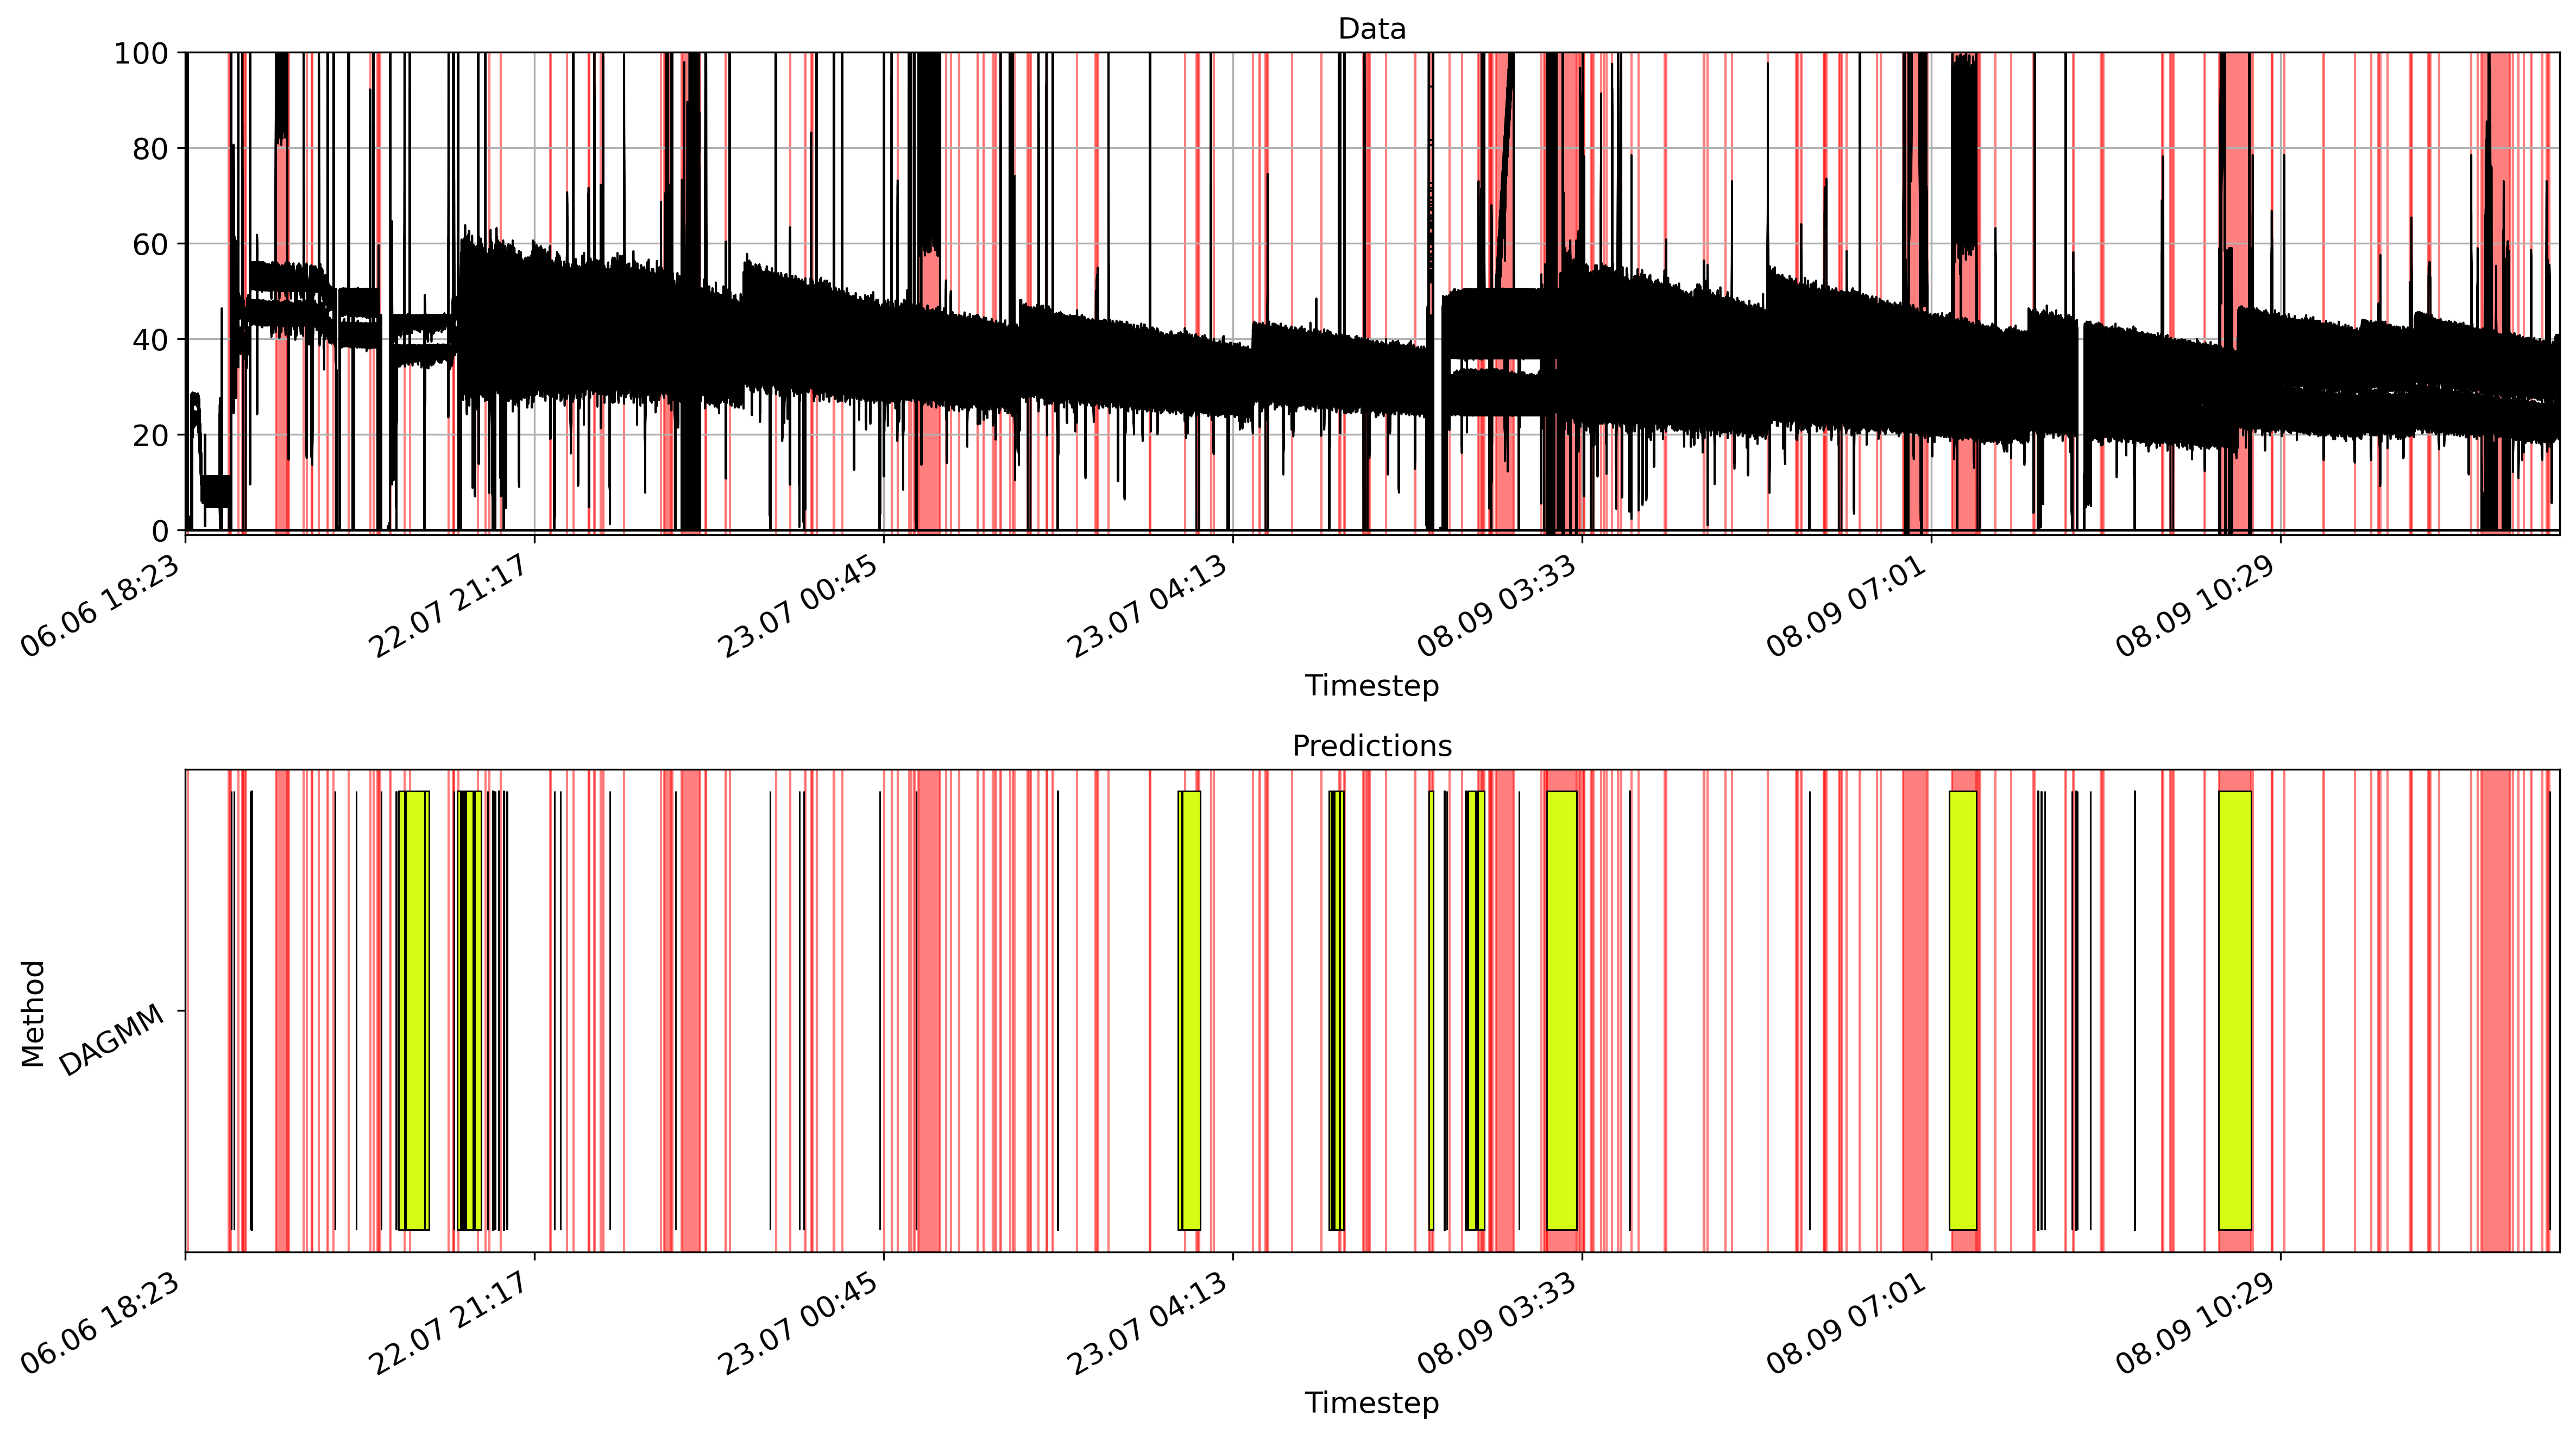

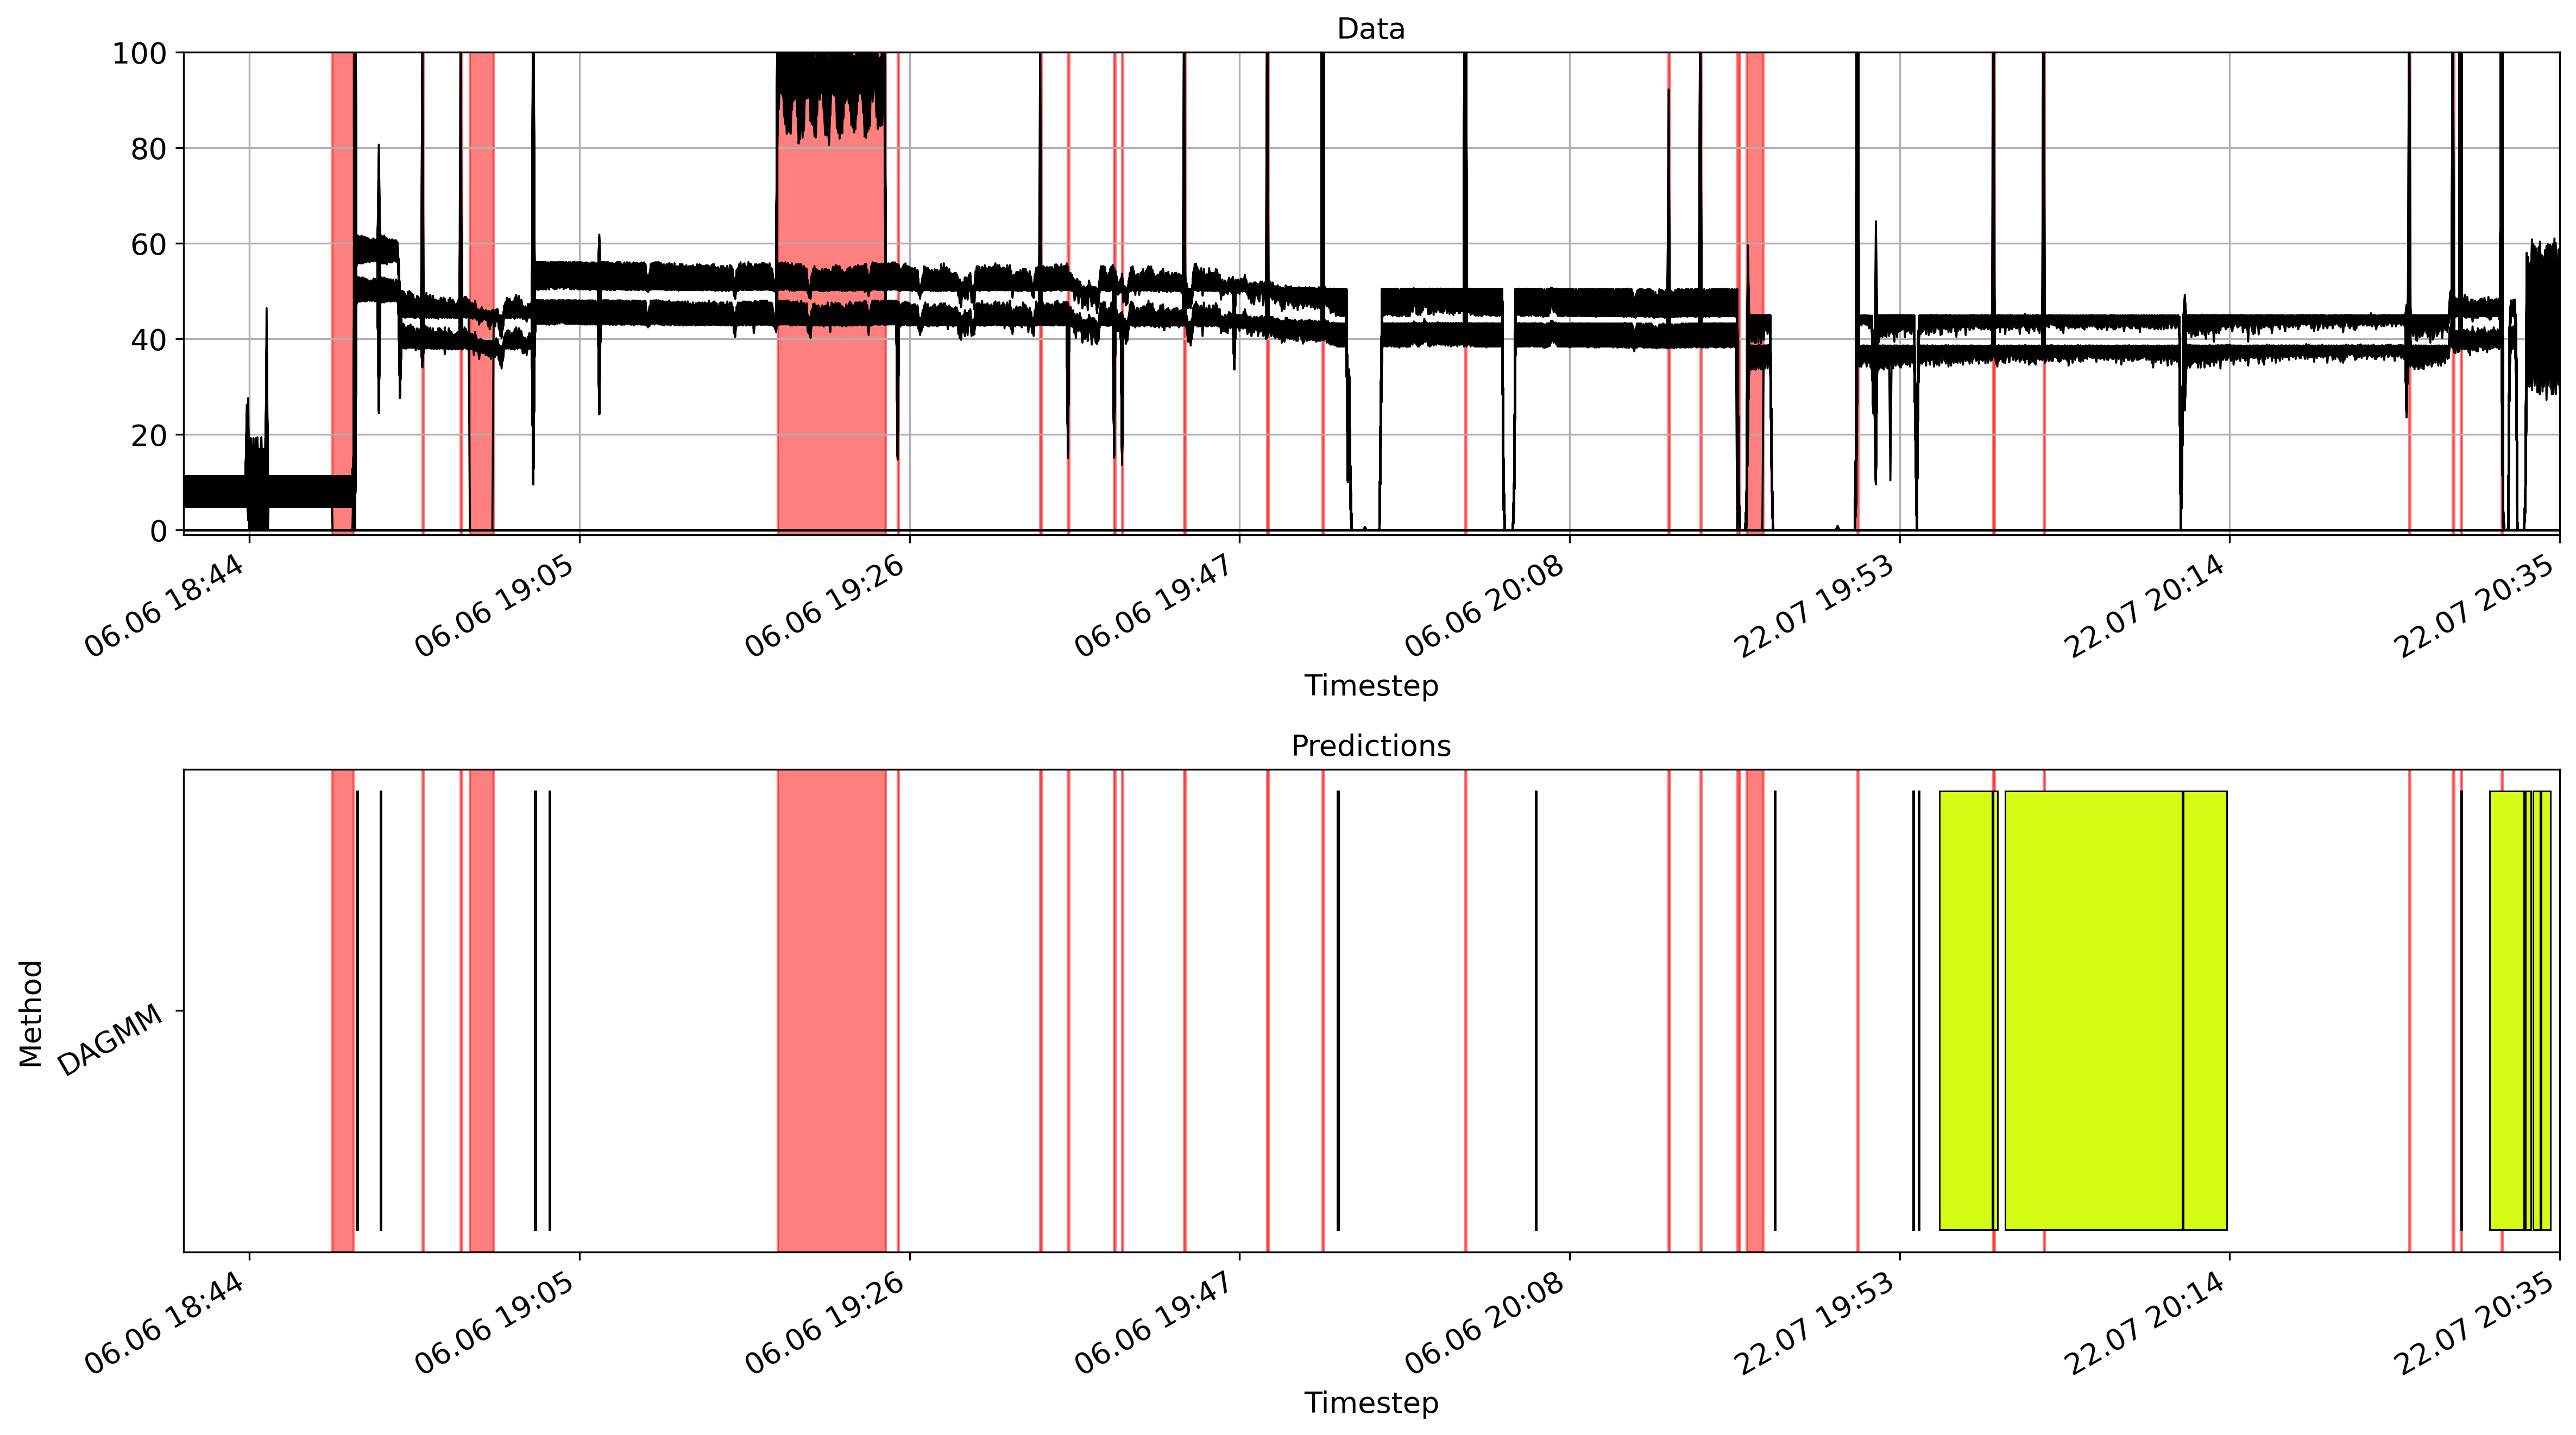

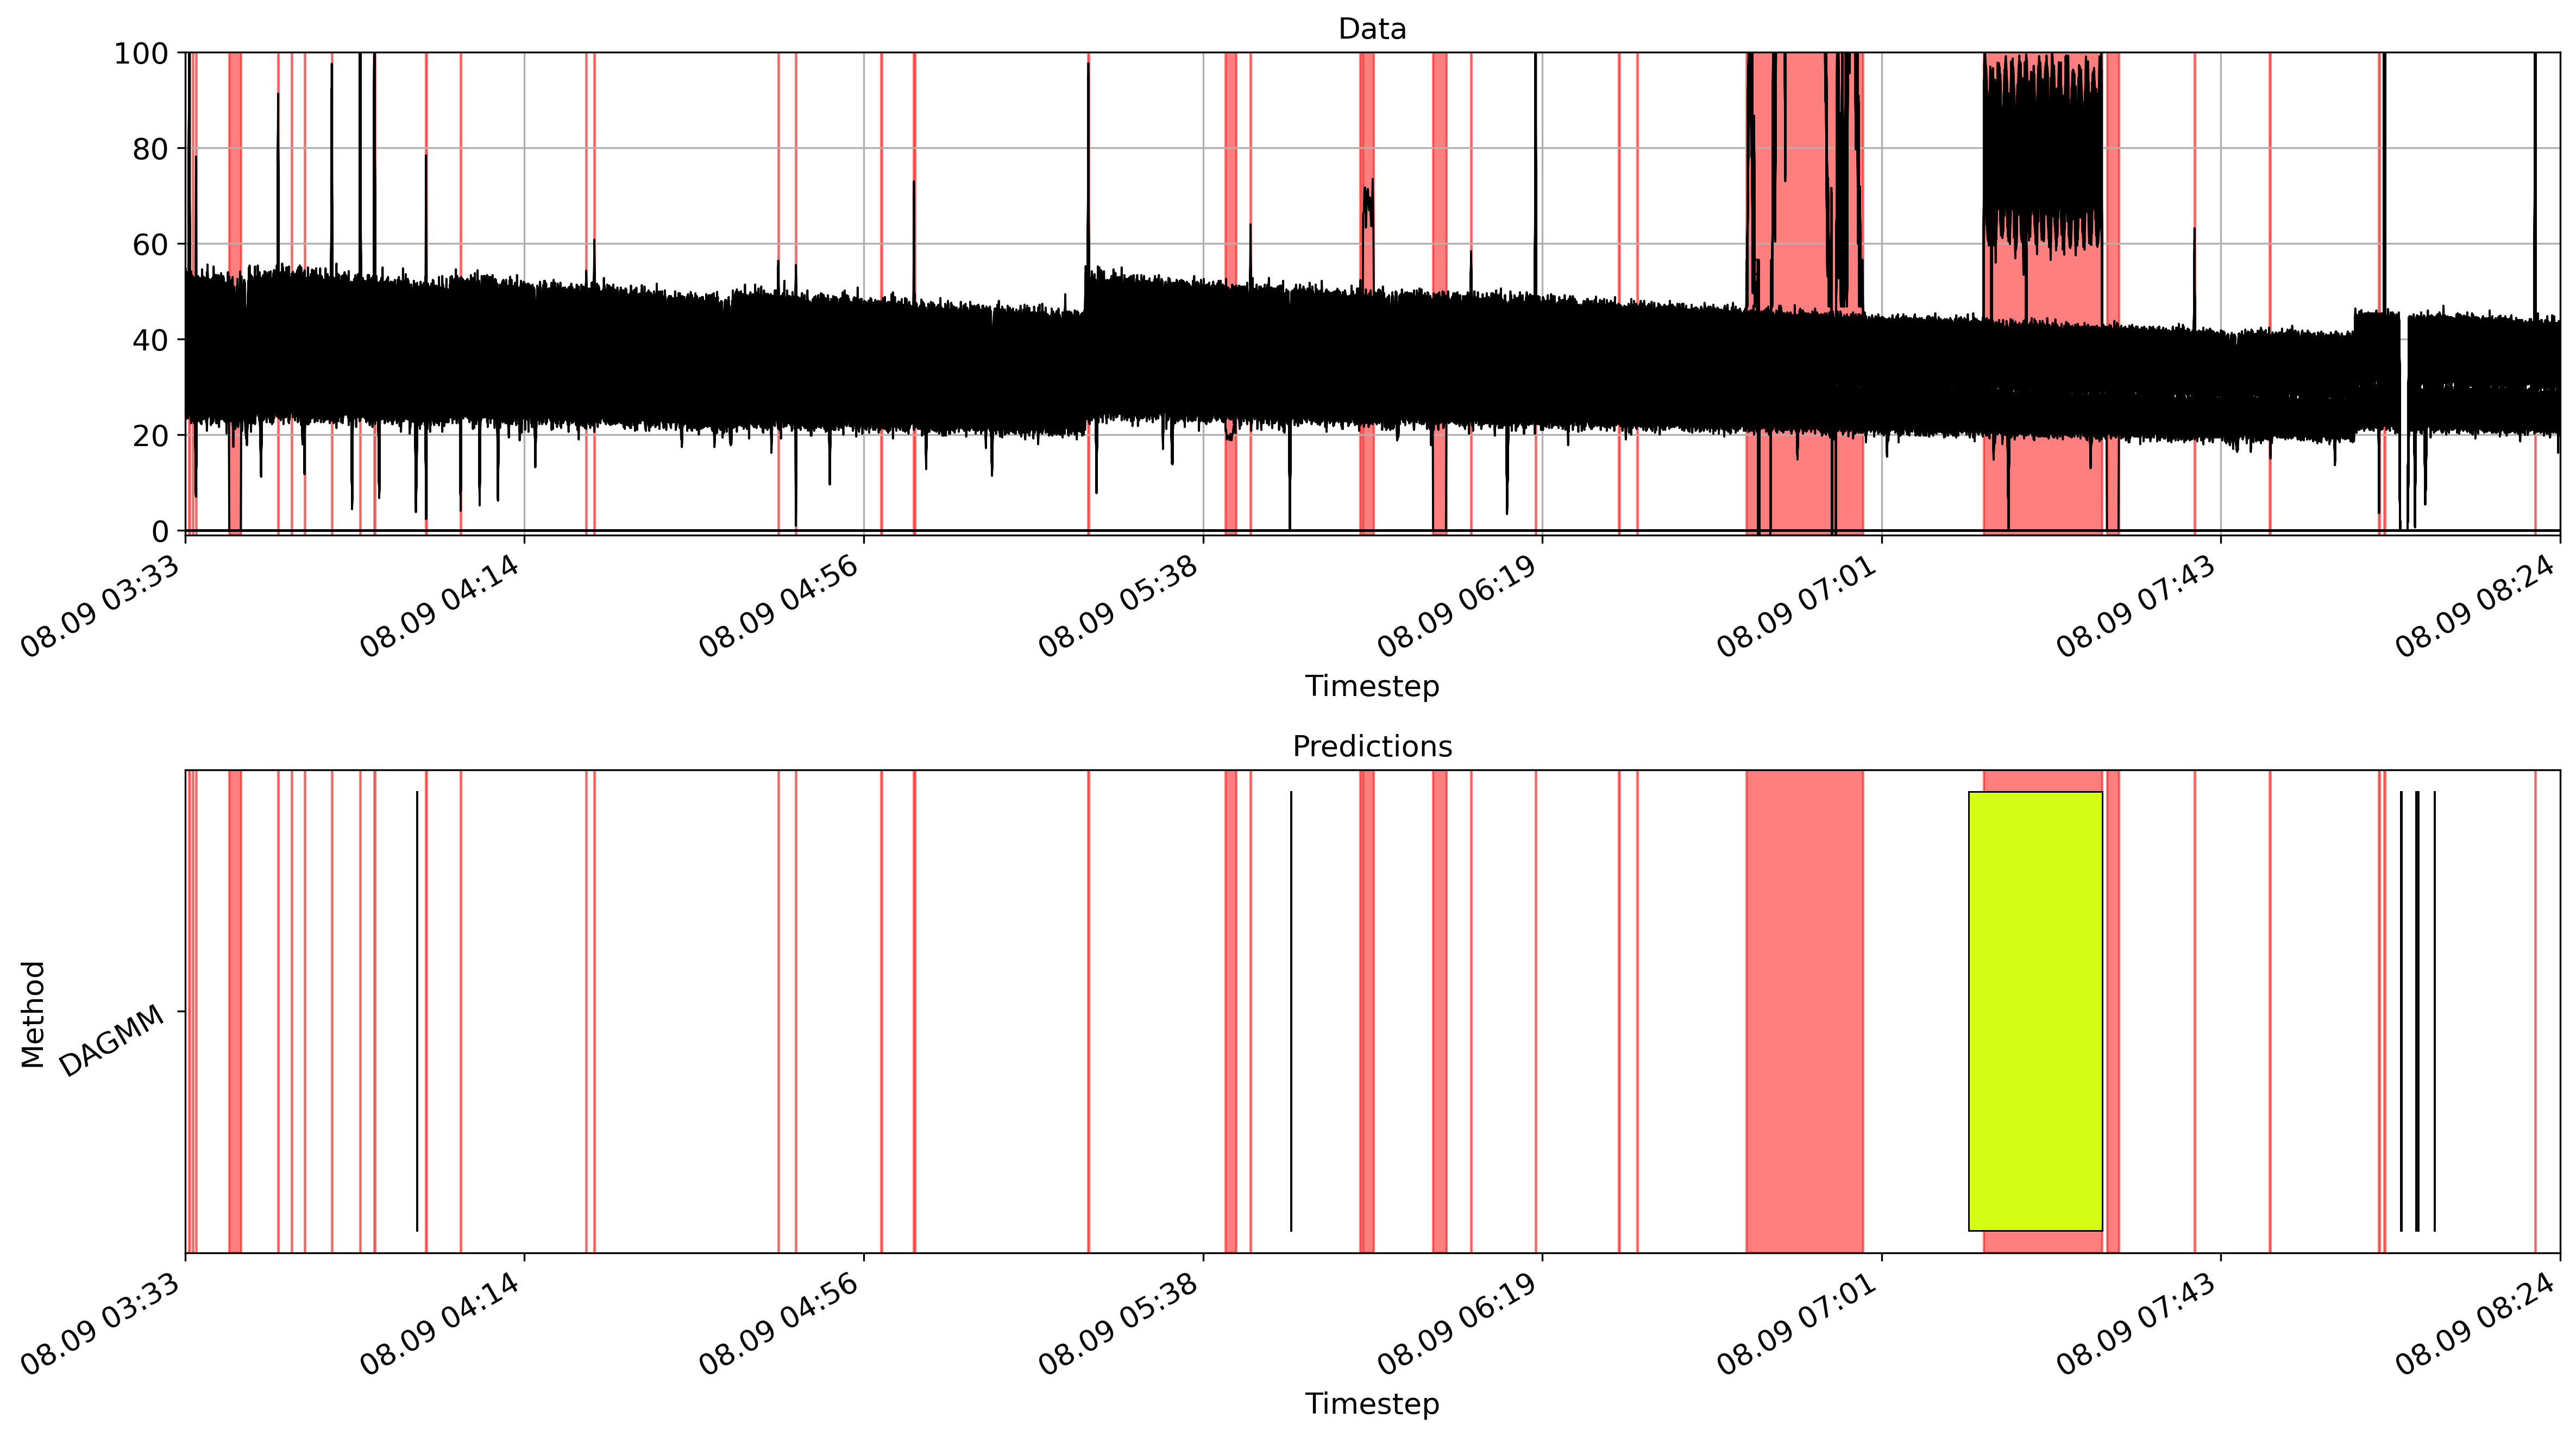

In [86]:
hlt_data_pd = pd.read_hdf('./datasets/hlt/unreduced_hlt_dcm_test_set_2018_x.h5')
print(hlt_data_pd.shape)
hlt_data_pd.fillna(0, inplace=True)

hlt_data_np = hlt_data_pd.to_numpy()

labels_pd = pd.read_hdf('./datasets/hlt/unreduced_hlt_dcm_test_set_2018_y.h5')
print(labels_pd.shape)
labels_np = labels_pd.to_numpy()

timestamps = labels_pd.index


# Convert the index to datetime format
timestamps_datetime = pd.to_datetime(timestamps)

# Apply strftime to format the datetime objects
formatted_timestamps = timestamps_datetime.strftime('%d.%m %H:%M')

labels_np = np.greater_equal(labels_np, 1)

plot_results(hlt_data_np,
                labels_np,
                formatted_timestamps,
                42)

